In [242]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')
%matplotlib inline

In [243]:
app = pd.read_pickle('app_cleaned.pickle')

In [244]:
app = app.drop_duplicates()

In [245]:
app = app.dropna(axis = 0)#remove the NAN

In [7]:
app.head()

,category,current_rating,description,id,is_InAppPurcased,is_multilingual,is_multiplatform,name,new_version_desc,num_current_rating,...,review2,review2_star,review3,review3_star,scrape_date,seller,size,update_date,url,version
0,Finance,1.80000,The JPay App lets you send money and email to ...,584959322,0,0,0,JPay,This update has a big new feature for the new ...,20.0,...,What is wrong with this freakin App? It keep s...,1.0,Emails are not sent and received in a timely m...,1.0,2017-03-13,"JPay, Inc.",13.0 MB,"Jan 20, 2017",https://itunes.apple.com/us/app/jpay/id5849593...,4.7
2,Finance,4.64497,Access your interactive Experian Credit Report...,1087101090,1,0,0,Experian - Free Credit Report,Bug fixes and other minor updates,169.0,...,This Experian app helps me measure my credit a...,5.0,I don't exactly like credit bureaus my experie...,5.0,2017-03-13,"CONSUMERINFO.COM, INC.",58.0 MB,"Feb 22, 2017",https://itunes.apple.com/us/app/experian-free-...,1.6.1
3,Finance,2.16667,Use the Vanguard app to check your accounts an...,335186209,0,0,0,Vanguard,See what's new! Have an IRA? Watch your progr...,30.0,...,The app is very easy to use and has tons of he...,5.0,My company used to use Fidelity for our retire...,1.0,2017-03-13,"The Vanguard Group, Inc.",49.0 MB,"Jan 22, 2017",https://itunes.apple.com/us/app/vanguard/id335...,7.1
4,Finance,4.60773,Conveniently manage your credit card account f...,1128712763,0,0,0,Credit One Bank Mobile,- Ability add an additional account if qualifi...,724.0,...,I am so fed up with this entire company! I'm g...,2.0,"I have no complaints, well one but its not a b...",5.0,2017-03-13,"Credit One Bank, National Association",42.8 MB,"Jan 31, 2017",https://itunes.apple.com/us/app/credit-one-ban...,1.4
5,Finance,4.34066,Be the first to know about news and market mov...,552799694,1,0,0,Seeking Alpha Portfolio,Performance improvements,91.0,...,SA offers a lot of information supplied by art...,5.0,I'm new to learning about stocks and managing ...,5.0,2017-03-13,Seeking Alpha Ltd.,46.2 MB,"Feb 14, 2017",https://itunes.apple.com/us/app/seeking-alpha-...,3.3.7


In [246]:
ratio = app['num_current_rating']/app['num_overall_rating']

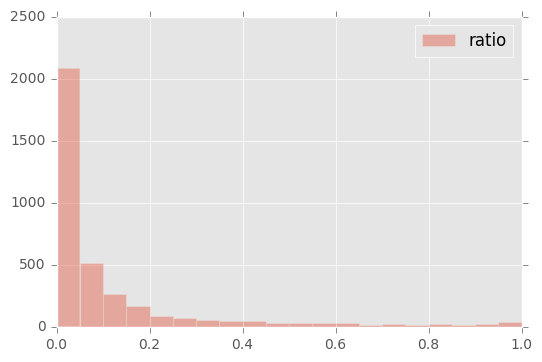

In [247]:
#use histogram to show the range of ratio
plt.hist(ratio,bins = 20, alpha = .4, label = 'ratio')
plt.legend()
plt.show()

according to the histogram, the ratios are mainly under 0.2.

In [249]:
index = ratio>0.05#get the index of ratio larger than 0.05

In [250]:
appfilter = app.loc[index]#filter the apps which number of current rating over number of overall rating larger than 0.1

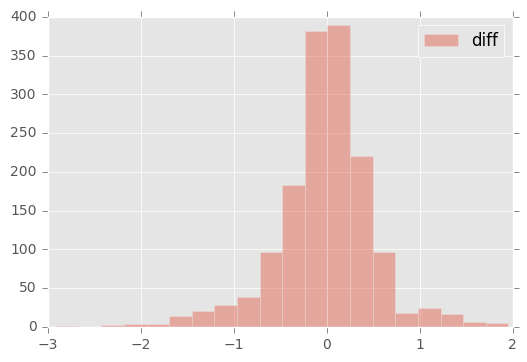

In [251]:
#use histogram to show the range of current_rating-overall_rating
plt.hist(appfilter['current_rating']-appfilter['overall_rating'],bins = 20, alpha = .4, label = 'diff')
plt.legend()
plt.show()

In [252]:
diff = appfilter['current_rating']-appfilter['overall_rating']

In [253]:
index2 = diff>=0.1#get the index of the difference larger than 0.1
index2b = diff<= -0.1#get the index of the difference smaller than -0.1

In [254]:
appinprove = appfilter.loc[index2]
appdecrease = appfilter.loc[index2b]

In [255]:
nvd = appinprove['new_version_desc']
nvdd = appdecrease['new_version_desc']

In [256]:
#compile documents
doc_complete = nvd.tolist()
doc_complete2 = nvdd.tolist()

In [257]:
#clean doc
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize
stop = stopwords.words('english')+list(string.punctuation)+['we','new','fix','io','updat','improv','bug',
                                                            'app','featur','perform','ad',"\'s","--","us"
                                                            ,"minor","support","iphon","issu","add","enhanc",
                                                           "user","pleas","10","7","experi","thank",
                                                           "version","experi","screen","\'\'","2","6","icon",
                                                           "stabil","review","5","``"]
def stem(tokens,stemmer = PorterStemmer().stem):
    stemwords = [stemmer(w.lower()) for w in tokens if w not in stop]
    return [w for w in stemwords if w not in stop]
def lemmatize(text):
    return stem(tokenize(text))

In [258]:
doc_clean = [lemmatize(doc) for doc in doc_complete]
doc_clean2 = [lemmatize(doc) for doc in doc_complete2]

In [259]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
dictionary2 = corpora.Dictionary(doc_clean2)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_term_matrix2 = [dictionary2.doc2bow(doc) for doc in doc_clean2]

In [260]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
ldamodel2 = Lda(doc_term_matrix2, num_topics=3, id2word = dictionary2, passes=50)

In [261]:
print(ldamodel.print_topics(num_topics=3, num_words=3))
print(ldamodel2.print_topics(num_topics=3, num_words=3))

[(0, u'0.007*"store" + 0.007*"game" + 0.006*"feedback"'), (1, u'0.009*"interfac" + 0.006*"free" + 0.006*"made"'), (2, u'0.009*"use" + 0.009*"feedback" + 0.008*"crash"')]
[(0, u'0.008*"use" + 0.008*"play" + 0.007*"make"'), (1, u'0.007*"-bug" + 0.007*"rate" + 0.006*"time"'), (2, u'0.010*"crash" + 0.008*"ipad" + 0.007*"optim"')]


__Improved app__

In [185]:
index_interfac = []
for i in range(len(doc_clean)):
    if 'interfac' in doc_clean[i]:
        index_interfac.append(True)
    else:
        index_interfac.append(False)

In [187]:
nvd[index_interfac][1342]

u'Minor Interface Improvements'

In [188]:
index_feedback = []
for i in range(len(doc_clean)):
    if 'feedback' in doc_clean[i]:
        index_feedback.append(True)
    else:
        index_feedback.append(False)

In [190]:
nvd[index_feedback][193]

u"- New truth or dare cards - Fixed bugs & improved design If you have any feedback or suggestions, tweet us @truthdareapp! We'd love to hear from you."

In [192]:
index_store = []
for i in range(len(doc_clean)):
    if 'store' in doc_clean[i]:
        index_store.append(True)
    else:
        index_store.append(False)

In [241]:
nvd[index_store][1024]

u'- Bug fixes If you enjoy our apps, please leave us a review on the App Store. Reviews help us stay motivated to keep the updates coming. Thanks!'

__improved pattern__:

1.some improvements on interface

2.ask for feedbacks

3.ask for reviews on app store

__Worsen app__

In [214]:
index_ipad = []
for i in range(len(doc_clean2)):
    if 'ipad' in doc_clean2[i]:
        index_ipad.append(True)
    else:
        index_ipad.append(False)

In [220]:
nvdd[index_ipad][1373]

u'Holy Quran Arabic text with side by side English translation by Maulvi Sher Ali. Retina display support for iPhone 4+. Universal app with iPad support. Swipe slides the pages left and right accordingly.'

In [222]:
index_music = []
for i in range(len(doc_clean2)):
    if 'music' in doc_clean2[i]:
        index_music.append(True)
    else:
        index_music.append(False)

In [232]:
nvdd[index_music][2157]

u'- Introducing Music Share! After a quick over-the-air update for your headphones, you can stream music or audio with a friend between two Bose headphones at the same time. - Bug fixes and improvements'

In [234]:
index_card = []
for i in range(len(doc_clean2)):
    if 'card' in doc_clean2[i]:
        index_card.append(True)
    else:
        index_card.append(False)

In [239]:
nvdd[index_card][646]

u'Based on your feedback weve made some enhancements and fixed bugs to help improve your experience.  Added swipe gesture to access the digital card from account summary. (Digital Card is available on most CareCredit accounts.)  Improvements on performance and stability. *We have heard some CareCredit customers are experiencing issues logging into the CareCredit App. Please know that our team is aware and we are looking for the best solution. We will be making regular updates to the app to improve your experience.'

__woren pattern__:

1.add more features on ipad version

2.add more features related to music function

3.the apps are designed for cards

In [262]:
import pyLDAvis.gensim

In [263]:
pyLDAvis.enable_notebook()
dec_improv = pyLDAvis.gensim.prepare(ldamodel,doc_term_matrix, dictionary)
dec_decrea = pyLDAvis.gensim.prepare(ldamodel2,doc_term_matrix2, dictionary2)

In [264]:
dec_improv

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      37.217382        1       1 -0.069049  0.074285
0      36.716878        1       2 -0.034224 -0.093100
1      26.065740        1       3  0.103273  0.018815, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
1052  Default  23.000000  interfac  23.000000  30.0000  30.0000
152   Default  21.000000    better  21.000000  29.0000  29.0000
395   Default  27.000000      game  27.000000  28.0000  28.0000
192   Default  19.000000      free  19.000000  27.0000  27.0000
1181  Default  20.000000    search  20.000000  26.0000  26.0000
2153  Default  11.000000  function  11.000000  25.0000  25.0000
1755  Default   8.000000     trail   8.000000  24.0000  24.0000
1586  Default  16.000000      -fix  16.000000  23.0000  23.0000
668   Default  15.000000         1  15.000000  22.0000  22.0000
1237  Default   7.000000    explor   7.000000  21.0000  21.0000
2054  Default   7.000000     audio   7.000000  20.0000  20.0000
861   Default  14.000000         3  14.000000  19.0000  19.0000
1479  Default  16.000000     devic  16.000000  18.0000  18.0000
1277  Default  10.000000      sale  10.000000  17.0000  17.0000
447   Default  10.000000      -bug  10.000000  16.0000  16.0000
1646  Default  11.000000      chat  11.000000  15.0000  15.0000
684   Default   9.000000      data   9.000000  14.0000  14.0000
595   Default  12.000000     gener  12.000000  13.0000  13.0000
1529  Default  14.000000         9  14.000000  12.0000  12.0000
689   Default  21.000000   favorit  21.000000  11.0000  11.0000
1816  Default  35.000000     crash  35.000000  10.0000  10.0000
1743  Default  35.000000       use  35.000000   9.0000   9.0000
2165  Default  21.000000      made  21.000000   8.0000   8.0000
2004  Default   5.000000       pin   5.000000   7.0000   7.0000
1953  Default   8.000000        =-   8.000000   6.0000   6.0000
195   Default   8.000000        -=   8.000000   5.0000   5.0000
1700  Default  14.000000  download  14.000000   4.0000   4.0000
983   Default  10.000000     speed  10.000000   3.0000   3.0000
1936  Default  11.000000     locat  11.000000   2.0000   2.0000
86    Default  15.000000     notif  15.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
730    Topic3   2.913457   magazin   3.695466   1.1068  -6.4989
86     Topic3   8.864745     notif  15.012939   0.8177  -5.3861
2165   Topic3  11.527233      made  21.091462   0.7404  -5.1235
1533   Topic3   5.015591     alert   7.458187   0.9478  -5.9556
595    Topic3   7.513258     gener  12.761423   0.8148  -5.5515
431    Topic3   6.033472      gift   9.737198   0.8659  -5.7709
1492   Topic3   8.038583      imag  15.081067   0.7154  -5.4839
1479   Topic3   8.392568     devic  16.624461   0.6610  -5.4408
1922   Topic3   6.739876   request  12.040092   0.7643  -5.6602
494    Topic3   4.551592     offer   6.708807   0.9566  -6.0527
1585   Topic3   8.887348       've  20.520235   0.5078  -5.3836
866    Topic3   9.657882       get  24.396713   0.4179  -5.3004
308    Topic3   6.981321      best  14.381607   0.6218  -5.6250
1156   Topic3   6.899923    design  14.388929   0.6096  -5.6367
1770   Topic3   7.565100       tap  19.057183   0.4206  -5.5446
156    Topic3   7.205531    easier  17.511282   0.4566  -5.5933
395    Topic3   8.746922      game  27.627268   0.1944  -5.3995
2021   Topic3   6.570085   purchas  15.201603   0.5057  -5.6857
1832   Topic3   6.511195      mode  15.208086   0.4962  -5.6947
981    Topic3   5.222858     touch   9.016481   0.7985  -5.9151
381    Topic3   7.564968      make  32.443761  -0.1114  -5.5447
230    Topic3   5.329238   sticker   9.795805   0.7358  -5.8950
1878   Topic3   5.438973    messag  12.145860   0.5412  -5.8746
1731   Topic3   6.492750     chang  30.954947  -0.2173  -5.6975
2175   Topic3   5.724193   display  16.

In [265]:
dec_decrea

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      38.940665        1       1 -0.022433 -0.101349
2      32.595667        1       2 -0.081840  0.068999
1      28.463668        1       3  0.104273  0.032350, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
1646  Default  19.000000     crash  19.000000  30.0000  30.0000
1429  Default  12.000000      -bug  12.000000  29.0000  29.0000
429   Default  14.000000     music  14.000000  28.0000  28.0000
1723  Default  22.000000      ipad  22.000000  27.0000  27.0000
1345  Default   9.000000     point   9.000000  26.0000  26.0000
1384  Default  10.000000         9  10.000000  25.0000  25.0000
1266  Default  20.000000      play  20.000000  24.0000  24.0000
882   Default   8.000000    reward   8.000000  23.0000  23.0000
762   Default  10.000000     beemo  10.000000  22.0000  22.0000
319   Default   7.000000    servic   7.000000  21.0000  21.0000
789   Default   8.000000    variou   8.000000  20.0000  20.0000
163   Default   6.000000   sunshin   6.000000  19.0000  19.0000
149   Default   9.000000   content   9.000000  18.0000  18.0000
1386  Default  19.000000     optim  19.000000  17.0000  17.0000
1477  Default  25.000000    includ  25.000000  16.0000  16.0000
1297  Default  13.000000         8  13.000000  15.0000  15.0000
565   Default   8.000000      live   8.000000  14.0000  14.0000
349   Default  11.000000   contact  11.000000  13.0000  13.0000
529   Default   7.000000     gener   7.000000  12.0000  12.0000
867   Default   6.000000  document   6.000000  11.0000  11.0000
1745  Default   6.000000        **   6.000000  10.0000  10.0000
69    Default  19.000000      work  19.000000   9.0000   9.0000
588   Default  11.000000         1  11.000000   8.0000   8.0000
475   Default  18.000000      time  18.000000   7.0000   7.0000
441   Default   9.000000    bugfix   9.000000   6.0000   6.0000
1549  Default   7.000000     recip   7.000000   5.0000   5.0000
1079  Default  13.000000    search  13.000000   4.0000   4.0000
1279  Default  11.000000    latest  11.000000   3.0000   3.0000
1949  Default  12.000000  function  12.000000   2.0000   2.0000
1693  Default   5.000000     could   5.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
529    Topic3   5.927809     gener   7.189856   1.0635  -5.6124
733    Topic3   3.825474     posit   5.056133   0.9776  -6.0503
1785   Topic3   3.331389   increas   4.327719   0.9949  -6.1886
990    Topic3   3.754036     creat   5.062002   0.9576  -6.0692
1086   Topic3   4.936336       via   7.193740   0.8800  -5.7954
475    Topic3  10.108031      time  18.307072   0.6626  -5.0787
1057   Topic3  10.614726      rate  19.727165   0.6368  -5.0298
1824   Topic3   4.978213   comment   7.928575   0.7911  -5.7870
588    Topic3   6.221013         1  11.563935   0.6366  -5.5641
1955   Topic3   5.299396   continu   9.452441   0.6779  -5.7244
1555   Topic3   7.500387     video  17.754958   0.3948  -5.3771
1120   Topic3   8.140747     share  20.636134   0.3264  -5.2951
549    Topic3   5.942673      love  11.724662   0.5770  -5.6099
49     Topic3   6.460978     would  13.837730   0.4949  -5.5262
159    Topic3   6.584245      free  16.313247   0.3492  -5.5074
1118   Topic3   4.526873      scan   7.944684   0.6941  -5.8820
1810   Topic3   6.168206     email  15.381181   0.3428  -5.5726
1059   Topic3   5.855438    design  13.881818   0.3933  -5.6247
1147   Topic3   7.364177      help  22.898259   0.1221  -5.3954
239    Topic3   5.061601      menu  10.333876   0.5428  -5.7703
1901   Topic3   5.061673      know  10.931112   0.4866  -5.7703
1365   Topic3   5.037170      look  11.032238   0.4726  -5.7752
109    Topic3   6.338257  feedback  21.414883   0.0391  -5.5454
790    Topic3   5.877431       get  19.358764   0.0645  -5.6209
1568   Topic3   4.955767       let  10.